In [16]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib

from ATARI.sammy_interface import sammy_classes, sammy_functions

from ATARI.ModelData.particle_pair import Particle_Pair
# from ATARI.ModelData.experimental_model import Experimental_Model
from ATARI.syndat.control import syndatOPT, Syndat_Control

from copy import copy

import ATARI.utils.plotting as myplot


In [17]:
sammypath = ''
assert(sammypath != '')

In [18]:
%matplotlib widget

# Overview

Syndat models for each measurement were developed, investigated, and saved in the associated example notebooks.
Here, we are going to load each Syndat model, add them to the Syndat Control module, and draw samples from them.
A few things to note, 
1) options should likely be re-defined as we want to ensure resonance and parameter sampling is turned on
2) the energy ranges can be overwritten s.t. you can draw samples for a smaller window.
3) The background function is the same for all 3 the transmission measurements, this can be implemented with the model correlations input


In [19]:
from ATARI.utils import atario

syndat_trans1mm = atario.load_syndat(os.path.join(os.getcwd(), "results", "SyndatModel_1mmT.pkl"))
syndat_trans3mm = atario.load_syndat(os.path.join(os.getcwd(), "results", "SyndatModel_3mmT.pkl"))
syndat_trans6mm = atario.load_syndat(os.path.join(os.getcwd(), "results", "SyndatModel_6mmT.pkl"))

syndat_cap1mm = atario.load_syndat(os.path.join(os.getcwd(), "results", "SyndatModel_1mmY.pkl"))
syndat_cap2mm = atario.load_syndat(os.path.join(os.getcwd(), "results", "SyndatModel_2mmY.pkl"))

In [20]:
energy_range_all = [197.5, 235]

Ta_pair = Particle_Pair(isotope="Ta181", formalism="XCT", energy_range=energy_range_all, 
                        ac=0.81271, M=180.948030, m=1, I=3.5, i=0.5, l_max=1)      

Ta_pair.add_spin_group(Jpi='3.0', J_ID=1,
                       D=9.0030,
                       gn2_avg=452.56615, gn2_dof=1,
                       gg2_avg=32.0, gg2_dof=100)

Ta_pair.add_spin_group(Jpi='4.0', J_ID=2,
                       D=8.3031,
                       gn2_avg=332.24347, gn2_dof=1,
                       gg2_avg=32.0, gg2_dof=100)

In [21]:
## get new syndat models in a smaller window

syndat_models = [syndat_trans1mm, syndat_trans3mm, syndat_trans6mm, syndat_cap1mm, syndat_cap2mm]
syndat_models_new = []
for each in syndat_models:
    syndat_models_new.append(each.truncate_energy_range(energy_range_all, return_copy=True))


In [22]:

rto = sammy_classes.SammyRunTimeOptions(sammypath,
                             {"Print"   :   True,
                              "bayes"   :   False,
                              "keep_runDIR"     : False,
                              "sammy_runDIR": "sammy_runDIR_gen"
                              })

## define model correlation for a_b parameters
trans_a_b = syndat_trans1mm.generative_measurement_model.model_parameters.a_b
model_correlations = [
                    {'models': [1,1,1,0,0],
                    'a_b'   : trans_a_b }
                        ]

syndat = Syndat_Control(Ta_pair,
                        syndat_models = syndat_models_new,
                        model_correlations=model_correlations,
                        sampleRES=True,
                        save_covariance=True,
                        save_raw_data=False)

In [23]:
syndat.sample(rto, num_samples=10)

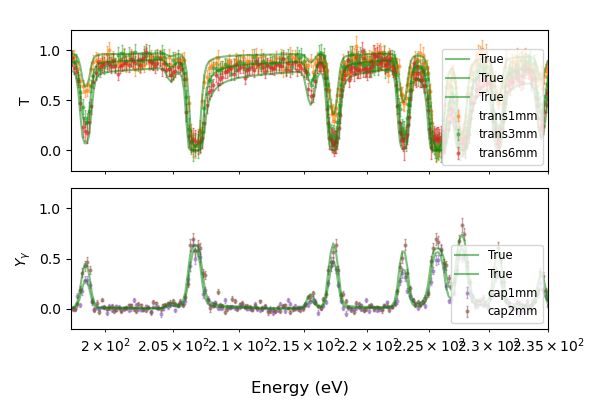

In [24]:
sample1 = syndat.get_sample(8)
datasets = [val.pw_reduced for key, val in sample1.items()]
experiments = [val.generative_experimental_model for val in syndat_models]

importlib.reload(myplot)
fig = myplot.plot_reduced_data_TY(datasets=datasets,
                            experiments=experiments,
                            xlim=energy_range_all,
                            plot_datasets_true=True
                            )

## testing the noise distribution of your syndat model
You can use the noise distribution test to verify the validity of linearity and normality assumptions in the propagation of measurement uncertainty.
If these assumptions are met, then the normalized residual should fall on a standard normal and the chi2 statistic should fall on a chi2 distribution with degrees of freedom equal to the number of data points.
This function performs this test for 10 randomly sampled "true experimental values" between 0 and 1 (the possible range for transmission or capture yield). 
For this reason, it is important to pass a copy of your syndat models to the function s.t. the settings to get changed.
For these Syndat_Models, the assumptions are not fully met, particularly for the transmission datasets.
From additional investigations, this was found to be due primarily to the power background function.
In the limit of very small uncertainty on measurement parameters, these assumptions will improve (see ATARI.tests.benchmarks.test_syndat_distributions).

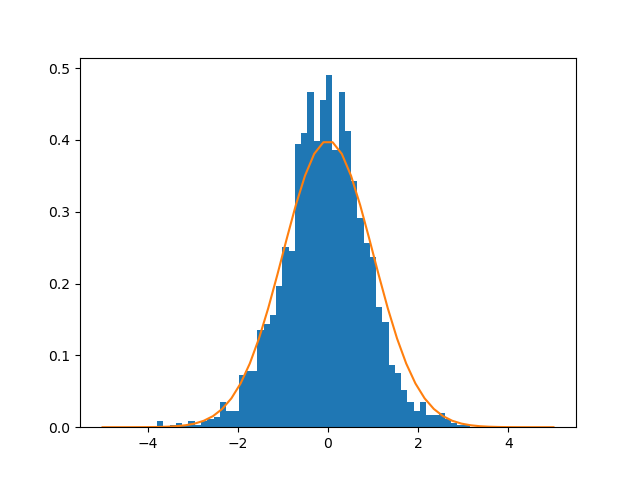

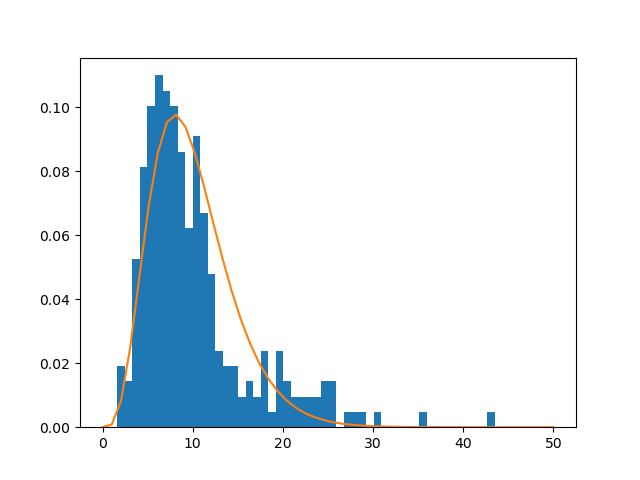

Mean of residual: 0.028241359446044112
Standard normal test: NormaltestResult(statistic=30.104183800737296, pvalue=2.903752164709234e-07)
Chi2 ks test: KstestResult(statistic=0.09733665875541264, pvalue=0.01632738119581283, statistic_location=7.790043537487785, statistic_sign=1)


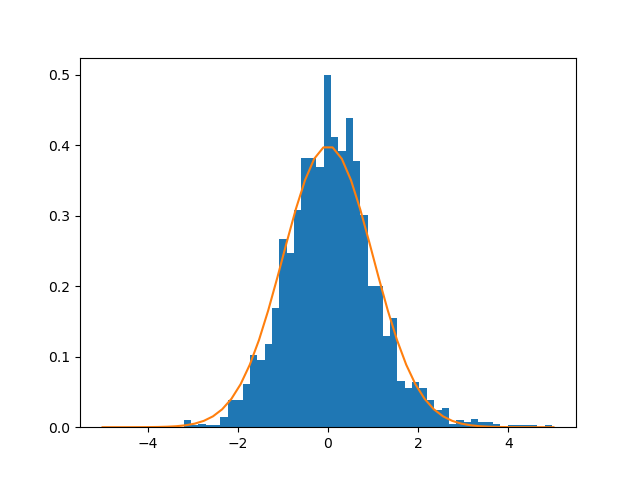

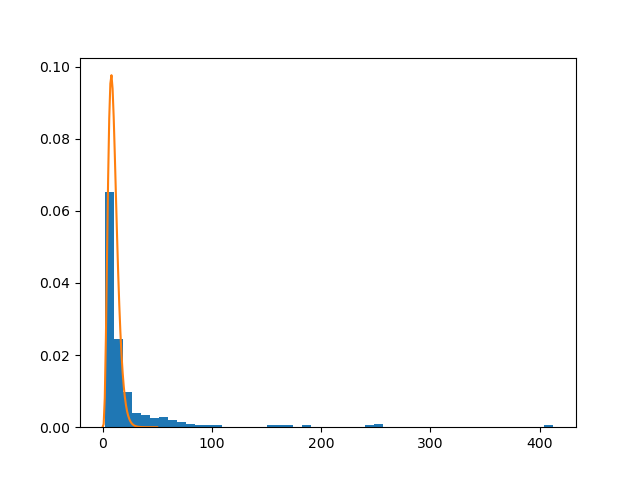

Mean of residual: 0.04683008162000181
Standard normal test: NormaltestResult(statistic=116.60865394587006, pvalue=4.7725723912244797e-26)
Chi2 ks test: KstestResult(statistic=0.23831099548920076, pvalue=5.615084630889888e-13, statistic_location=17.84194792876874, statistic_sign=-1)


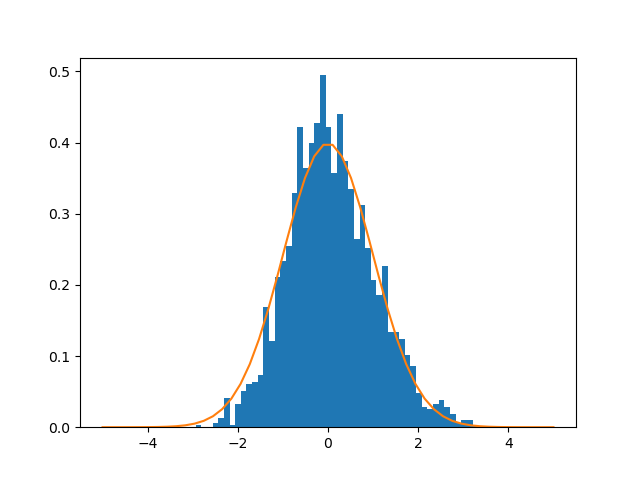

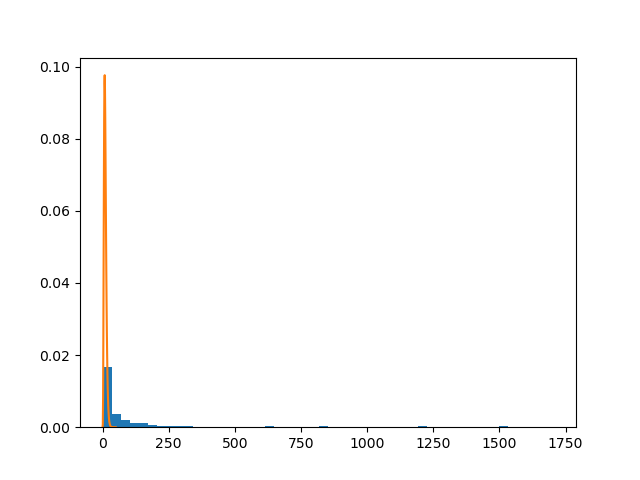

Mean of residual: 0.25015740758959915
Standard normal test: NormaltestResult(statistic=30.049372835750106, pvalue=2.9844313705901095e-07)
Chi2 ks test: KstestResult(statistic=0.5177216120179629, pvalue=8.216521288702478e-63, statistic_location=19.89328044673447, statistic_sign=-1)


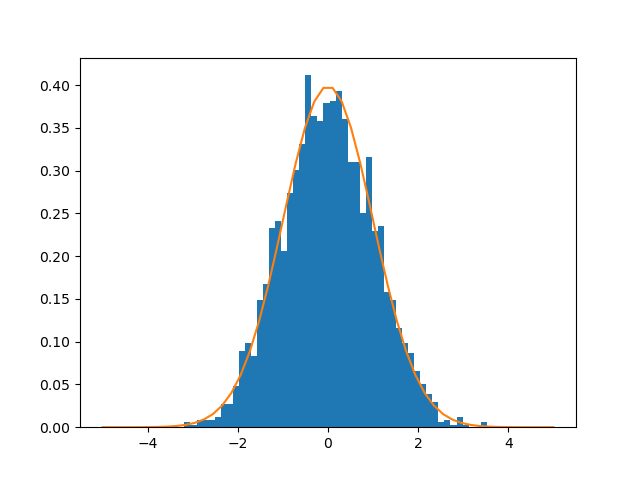

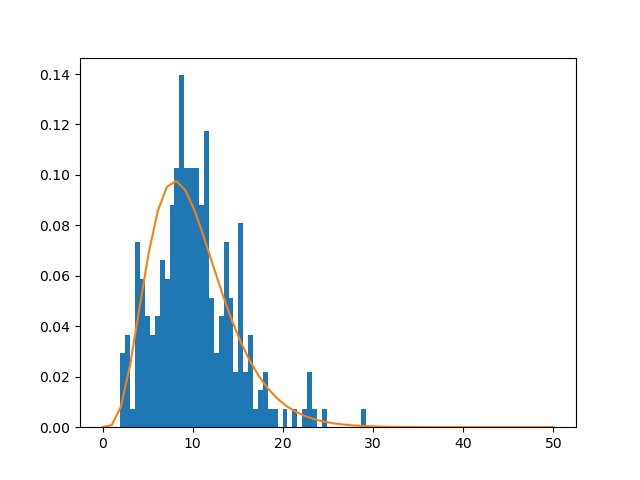

Mean of residual: 0.004667526736338276
Standard normal test: NormaltestResult(statistic=4.655962415845049, pvalue=0.09749236537186771)
Chi2 ks test: KstestResult(statistic=0.08730952973511441, pvalue=0.04159673129604835, statistic_location=7.878634784893034, statistic_sign=-1)


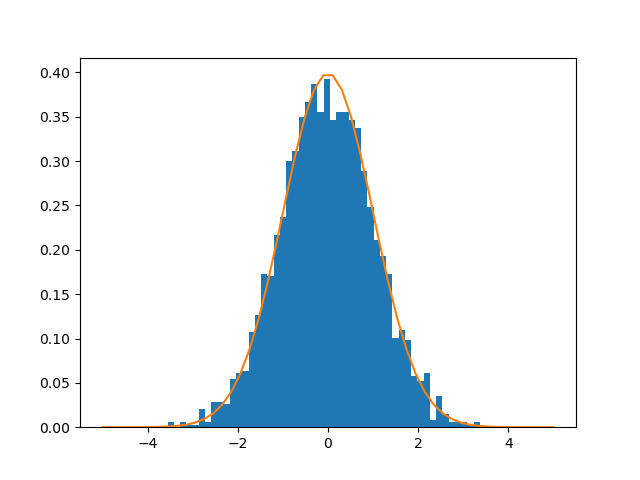

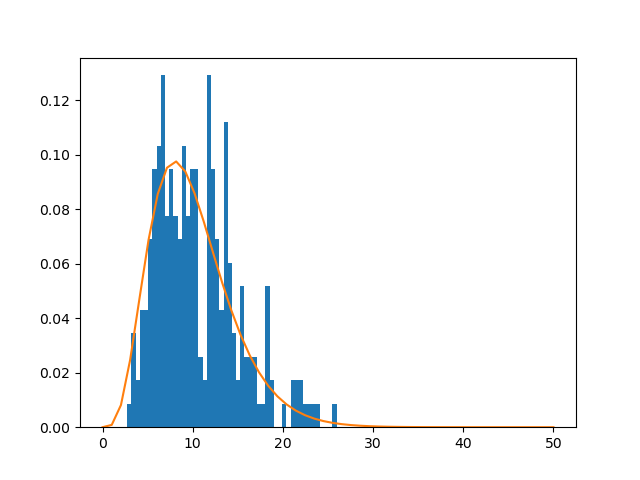

Mean of residual: 0.0021077298833771323
Standard normal test: NormaltestResult(statistic=0.03729674520383368, pvalue=0.9815244324535191)
Chi2 ks test: KstestResult(statistic=0.10096772317813596, pvalue=0.011348786056467325, statistic_location=11.737163509598258, statistic_sign=-1)


In [25]:
from ATARI.syndat.tests import noise_distribution_test, noise_distribution_test2
from copy import deepcopy

mean = []
norm_test = []
kstest = []
for each in syndat_models_new:
    mean_of_residual, norm_test_on_residual, kstest_on_chi2 = noise_distribution_test(deepcopy(each), print_out=True, ipert=250, energy_range = [150,2500])
    mean.append(mean_of_residual)
    norm_test.append(norm_test_on_residual)
    kstest.append(kstest_on_chi2)

# Saving the Syndat Control module and all samples
Similar to the syndat_models, you can use the atario function to save the syndat_control object as a pickle. 
This is commented out because an existing pkl file is loaded

In [26]:

atario.save_syndat_control(syndat, os.path.join(os.getcwd(), "results", "SyndatModel_All_200_235.pkl"))